In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import packets and libraries
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2,ResNet50

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
IMAGE_SIZE = 256
EPOCHS = 30
BATCH = 10
LR = 1e-4

PATH = "/content/drive/MyDrive//OTU-2D-Dataset-main/OTU-2D-Dataset-main/dataset_split"

In [ ]:
import os
from glob import glob
import cv2
import numpy as np
import tensorflow as tf

def load_data(path):
    def load_split(split):
        if split == 'train':
            image_dir = os.path.join(path, split, 'augmented_haze')
            original_images = sorted(glob(os.path.join(image_dir, 'original_*.JPG')))
            haze_images = sorted(glob(os.path.join(image_dir, 'haze_*.JPG')))
            images = original_images + haze_images

            masks = sorted(glob(os.path.join(path, split, 'masks', '*')))
            if len(masks) * 2 != len(images):
                raise ValueError(f"Số lượng mask x2 ({len(masks)*2}) không bằng số lượng ảnh ({len(images)})")

            masks = masks * 2
        else:
            images = sorted(glob(os.path.join(path, split, 'images', '*')))
            masks = sorted(glob(os.path.join(path, split, 'masks', '*')))

        paired = list(zip(images, masks))
        np.random.shuffle(paired)
        images, masks = zip(*paired)
        return list(images), list(masks)

    train_x, train_y = load_split('train')
    valid_x, valid_y = load_split('validation')
    test_x, test_y   = load_split('test')
    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [ ]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(PATH)

print("Training data:", len(train_x))
print("Validation data:", len(valid_x))
print("Testing data:", len(test_x))

In [ ]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH, repeat=True)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH, repeat=True)
test_dataset  = tf_dataset(test_x, test_y, batch=BATCH, repeat=False)

In [ ]:
def read_image(path):
    if isinstance(path, bytes):
        path = path.decode('utf-8')
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    if x is None:
        raise ValueError(f"Could not read image: {path}")
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x.astype(np.float32) / 255.0
    return x

def read_mask(path):
    if isinstance(path, bytes):
        path = path.decode('utf-8')
    y = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if y is None:
        raise ValueError(f"Could not read mask: {path}")
    y = cv2.resize(y, (IMAGE_SIZE, IMAGE_SIZE))
    y = y.astype(np.float32) / 255.0
    _, y = cv2.threshold(y, 0, 1, cv2.THRESH_BINARY)
    y = np.expand_dims(y, axis=-1)
    return y

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    return x, y

def tf_dataset(x, y, batch=8, repeat=True):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=len(x))
    dataset = dataset.batch(batch)
    if repeat:
        dataset = dataset.repeat()
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

# Constants
beta = 0.25
alpha = 0.26
gamma = 2.3
epsilon = 1e-7
smooth = 1e-15

# Dice Coefficient
def dice_coef(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + epsilon) / (
            tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + epsilon)

# Sensitivity
def sensitivity(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    return true_positives / (possible_positives + epsilon)

# Specificity
def specificity(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_negatives = tf.reduce_sum(tf.round(tf.clip_by_value((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = tf.reduce_sum(tf.round(tf.clip_by_value(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + epsilon)

# Convert probabilities to logits
def convert_to_logits(y_pred):
    y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
    return tf.math.log(y_pred / (1 - y_pred))

# Weighted cross entropy
def weighted_cross_entropyloss(y_true, y_pred):
    y_pred = convert_to_logits(y_pred)
    pos_weight = beta / (1 - beta)
    loss = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred, labels=y_true, pos_weight=pos_weight)
    return tf.reduce_mean(loss)

# Dice Loss
def generalized_dice_coefficient(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - generalized_dice_coefficient(y_true, y_pred)

# Confusion metrics
def confusion(y_true, y_pred):
    y_pred = tf.cast(tf.clip_by_value(y_pred, 0, 1), tf.float32)
    y_true = tf.cast(tf.clip_by_value(y_true, 0, 1), tf.float32)
    y_pred_neg = 1 - y_pred
    y_neg = 1 - y_true
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum(y_neg * y_pred)
    fn = tf.reduce_sum(y_true * y_pred_neg)
    precision = (tp + smooth) / (tp + fp + smooth)
    recall = (tp + smooth) / (tp + fn + smooth)
    return precision, recall

# True positive
def true_positive(y_true, y_pred):
    y_pred = tf.round(tf.clip_by_value(y_pred, 0, 1))
    y_true = tf.round(tf.clip_by_value(y_true, 0, 1))
    return (tf.reduce_sum(y_true * y_pred) + smooth) / (tf.reduce_sum(y_true) + smooth)

# True negative
def true_negative(y_true, y_pred):
    y_pred = tf.round(tf.clip_by_value(y_pred, 0, 1))
    y_true = tf.round(tf.clip_by_value(y_true, 0, 1))
    y_pred_neg = 1 - y_pred
    y_neg = 1 - y_true
    return (tf.reduce_sum(y_neg * y_pred_neg) + smooth) / (tf.reduce_sum(y_neg) + smooth)

# Jaccard
def jaccard_similarity(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f + y_pred_f - y_true_f * y_pred_f)
    return intersection / (union + epsilon)

def jaccard_loss(y_true, y_pred):
    return 1 - jaccard_similarity(y_true, y_pred)

# Binary Dice
def binary_dice(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)



In [ ]:
import tensorflow as tf
import os
import random
import numpy as np
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from keras.utils import normalize
from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras.models import Model

# Convolutional block
def conv_block(x, num_filters):
    x = L.Conv2D(num_filters, 3, padding="same", kernel_initializer='he_normal', activation="relu")(x)
    x = L.Conv2D(num_filters, 3, padding="same", kernel_initializer='he_normal', activation="relu")(x)
    return x

# Encoder block
def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    p = L.MaxPool2D((2, 2))(x)
    return x, p

# Decoder block
def decoder_block(x, s, num_filters):
    x = L.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(x)
    x = L.Concatenate()([x, s])
    x = conv_block(x, num_filters)
    return x

# Build U-Net model
def build_unet(input_shape):
    inputs = L.Input(input_shape)

    c1, p1 = encoder_block(inputs, 64)
    c2, p2 = encoder_block(p1, 128)
    c3, p3 = encoder_block(p2, 256)
    c4, p4 = encoder_block(p3, 512)

    c5 = conv_block(p4, 1024)

    d6 = decoder_block(c5, c4, 512)
    d7 = decoder_block(d6, c3, 256)
    d8 = decoder_block(d7, c2, 128)
    d9 = decoder_block(d8, c1, 64)

    outputs = L.Conv2D(1, 1, padding="same", activation="sigmoid")(d9)

    model = Model(inputs, outputs)
    return model


In [ ]:
input = (256, 256, 3)
model = build_unet(input)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = "unet_with_and_without_haze.h5"

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch'
)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False),
    checkpoint_callback
]

In [ ]:
train_steps = len(train_x) // BATCH
valid_steps = len(valid_x) // BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1

print(train_steps)
print(valid_steps)

236
15


In [ ]:

opt = tf.keras.optimizers.Nadam(LR,clipnorm=1.0)
metrics = [dice_coef, jaccard_similarity, tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]

model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=30,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)


Epoch 1/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - dice_coef: 0.4338 - jaccard_similarity: 0.2949 - loss: 0.5662 - precision: 0.2645 - recall: 0.7754
Epoch 1: val_loss improved from inf to 0.29741, saving model to unet_with_and_without_haze.h5


236/236 ━━━━━━━━━━━━━━━━━━━━ 708s 1s/step - dice_coef: 0.4344 - jaccard_similarity: 0.2954 - loss: 0.5656 - precision: 0.2650 - recall: 0.7753 - val_dice_coef: 0.7048 - val_jaccard_similarity: 0.5497 - val_loss: 0.2974 - val_precision: 0.6656 - val_recall: 0.7675 - learning_rate: 1.0000e-04
Epoch 2/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - dice_coef: 0.6914 - jaccard_similarity: 0.5349 - loss: 0.3086 - precision: 0.6690 - recall: 0.7365
Epoch 2: val_loss improved from 0.29741 to 0.26631, saving model to unet_with_and_without_haze.h5


236/236 ━━━━━━━━━━━━━━━━━━━━ 132s 561ms/step - dice_coef: 0.6915 - jaccard_similarity: 0.5350 - loss: 0.3085 - precision: 0.6691 - recall: 0.7365 - val_dice_coef: 0.7357 - val_jaccard_similarity: 0.5904 - val_loss: 0.2663 - val_precision: 0.7497 - val_recall: 0.7527 - learning_rate: 1.0000e-04
Epoch 3/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - dice_coef: 0.7422 - jaccard_similarity: 0.5956 - loss: 0.2578 - precision: 0.7373 - recall: 0.7669
Epoch 3: val_loss improved from 0.26631 to 0.24443, saving model to unet_with_and_without_haze.h5


236/236 ━━━━━━━━━━━━━━━━━━━━ 201s 748ms/step - dice_coef: 0.7421 - jaccard_similarity: 0.5956 - loss: 0.2579 - precision: 0.7373 - recall: 0.7669 - val_dice_coef: 0.7597 - val_jaccard_similarity: 0.6217 - val_loss: 0.2444 - val_precision: 0.7751 - val_recall: 0.7789 - learning_rate: 1.0000e-04
Epoch 4/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - dice_coef: 0.7648 - jaccard_similarity: 0.6256 - loss: 0.2352 - precision: 0.7746 - recall: 0.7790
Epoch 4: val_loss improved from 0.24443 to 0.22091, saving model to unet_with_and_without_haze.h5


236/236 ━━━━━━━━━━━━━━━━━━━━ 144s 610ms/step - dice_coef: 0.7648 - jaccard_similarity: 0.6256 - loss: 0.2352 - precision: 0.7746 - recall: 0.7790 - val_dice_coef: 0.7792 - val_jaccard_similarity: 0.6413 - val_loss: 0.2209 - val_precision: 0.8157 - val_recall: 0.7515 - learning_rate: 1.0000e-04
Epoch 5/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - dice_coef: 0.7816 - jaccard_similarity: 0.6467 - loss: 0.2184 - precision: 0.7826 - recall: 0.7973
Epoch 5: val_loss did not improve from 0.22091
236/236 ━━━━━━━━━━━━━━━━━━━━ 197s 781ms/step - dice_coef: 0.7817 - jaccard_similarity: 0.6467 - loss: 0.2183 - precision: 0.7827 - recall: 0.7974 - val_dice_coef: 0.7247 - val_jaccard_similarity: 0.5717 - val_loss: 0.2747 - val_precision: 0.6130 - val_recall: 0.9200 - learning_rate: 1.0000e-04
Epoch 6/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - dice_coef: 0.7943 - jaccard_similarity: 0.6643 - loss: 0.2057 - precision: 0.7855 - recall: 0.8161
Epoch 6: val_loss improved from 0.22091 to 0.21061, s

236/236 ━━━━━━━━━━━━━━━━━━━━ 132s 559ms/step - dice_coef: 0.7944 - jaccard_similarity: 0.6644 - loss: 0.2056 - precision: 0.7855 - recall: 0.8162 - val_dice_coef: 0.7876 - val_jaccard_similarity: 0.6531 - val_loss: 0.2106 - val_precision: 0.8519 - val_recall: 0.7493 - learning_rate: 1.0000e-04
Epoch 7/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - dice_coef: 0.8263 - jaccard_similarity: 0.7084 - loss: 0.1737 - precision: 0.8278 - recall: 0.8365
Epoch 7: val_loss improved from 0.21061 to 0.19498, saving model to unet_with_and_without_haze.h5


236/236 ━━━━━━━━━━━━━━━━━━━━ 155s 557ms/step - dice_coef: 0.8263 - jaccard_similarity: 0.7084 - loss: 0.1737 - precision: 0.8278 - recall: 0.8365 - val_dice_coef: 0.8043 - val_jaccard_similarity: 0.6764 - val_loss: 0.1950 - val_precision: 0.8367 - val_recall: 0.7798 - learning_rate: 1.0000e-04
Epoch 8/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - dice_coef: 0.8338 - jaccard_similarity: 0.7198 - loss: 0.1662 - precision: 0.8400 - recall: 0.8422
Epoch 8: val_loss did not improve from 0.19498
236/236 ━━━━━━━━━━━━━━━━━━━━ 200s 747ms/step - dice_coef: 0.8338 - jaccard_similarity: 0.7198 - loss: 0.1662 - precision: 0.8401 - recall: 0.8423 - val_dice_coef: 0.7904 - val_jaccard_similarity: 0.6593 - val_loss: 0.2060 - val_precision: 0.8931 - val_recall: 0.7199 - learning_rate: 1.0000e-04
Epoch 9/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - dice_coef: 0.8566 - jaccard_similarity: 0.7530 - loss: 0.1434 - precision: 0.8677 - recall: 0.8563
Epoch 9: val_loss improved from 0.19498 to 0.18208, s

236/236 ━━━━━━━━━━━━━━━━━━━━ 145s 616ms/step - dice_coef: 0.8566 - jaccard_similarity: 0.7530 - loss: 0.1434 - precision: 0.8677 - recall: 0.8563 - val_dice_coef: 0.8203 - val_jaccard_similarity: 0.7002 - val_loss: 0.1821 - val_precision: 0.8534 - val_recall: 0.7996 - learning_rate: 1.0000e-04
Epoch 10/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - dice_coef: 0.8788 - jaccard_similarity: 0.7867 - loss: 0.1212 - precision: 0.8868 - recall: 0.8823
Epoch 10: val_loss improved from 0.18208 to 0.18044, saving model to unet_with_and_without_haze.h5


236/236 ━━━━━━━━━━━━━━━━━━━━ 142s 587ms/step - dice_coef: 0.8788 - jaccard_similarity: 0.7867 - loss: 0.1212 - precision: 0.8868 - recall: 0.8823 - val_dice_coef: 0.8151 - val_jaccard_similarity: 0.6945 - val_loss: 0.1804 - val_precision: 0.8750 - val_recall: 0.7953 - learning_rate: 1.0000e-04
Epoch 11/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - dice_coef: 0.8995 - jaccard_similarity: 0.8192 - loss: 0.1005 - precision: 0.9070 - recall: 0.8986
Epoch 11: val_loss improved from 0.18044 to 0.16066, saving model to unet_with_and_without_haze.h5


236/236 ━━━━━━━━━━━━━━━━━━━━ 143s 590ms/step - dice_coef: 0.8995 - jaccard_similarity: 0.8192 - loss: 0.1005 - precision: 0.9070 - recall: 0.8986 - val_dice_coef: 0.8387 - val_jaccard_similarity: 0.7241 - val_loss: 0.1607 - val_precision: 0.8620 - val_recall: 0.8277 - learning_rate: 1.0000e-04
Epoch 12/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - dice_coef: 0.9080 - jaccard_similarity: 0.8337 - loss: 0.0920 - precision: 0.9168 - recall: 0.9087
Epoch 12: val_loss did not improve from 0.16066
236/236 ━━━━━━━━━━━━━━━━━━━━ 137s 582ms/step - dice_coef: 0.9080 - jaccard_similarity: 0.8337 - loss: 0.0920 - precision: 0.9168 - recall: 0.9087 - val_dice_coef: 0.8310 - val_jaccard_similarity: 0.7133 - val_loss: 0.1699 - val_precision: 0.8872 - val_recall: 0.7838 - learning_rate: 1.0000e-04
Epoch 13/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - dice_coef: 0.9207 - jaccard_similarity: 0.8543 - loss: 0.0793 - precision: 0.9291 - recall: 0.9161
Epoch 13: val_loss improved from 0.16066 to 0.1540

236/236 ━━━━━━━━━━━━━━━━━━━━ 133s 563ms/step - dice_coef: 0.9207 - jaccard_similarity: 0.8543 - loss: 0.0793 - precision: 0.9291 - recall: 0.9161 - val_dice_coef: 0.8451 - val_jaccard_similarity: 0.7346 - val_loss: 0.1540 - val_precision: 0.8712 - val_recall: 0.8311 - learning_rate: 1.0000e-04
Epoch 14/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - dice_coef: 0.9306 - jaccard_similarity: 0.8714 - loss: 0.0694 - precision: 0.9368 - recall: 0.9285
Epoch 14: val_loss did not improve from 0.15401
236/236 ━━━━━━━━━━━━━━━━━━━━ 137s 582ms/step - dice_coef: 0.9306 - jaccard_similarity: 0.8714 - loss: 0.0694 - precision: 0.9368 - recall: 0.9285 - val_dice_coef: 0.8248 - val_jaccard_similarity: 0.7086 - val_loss: 0.1756 - val_precision: 0.8534 - val_recall: 0.8255 - learning_rate: 1.0000e-04
Epoch 15/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - dice_coef: 0.9358 - jaccard_similarity: 0.8804 - loss: 0.0642 - precision: 0.9436 - recall: 0.9350
Epoch 15: val_loss did not improve from 0.15401
23

236/236 ━━━━━━━━━━━━━━━━━━━━ 144s 610ms/step - dice_coef: 0.9573 - jaccard_similarity: 0.9185 - loss: 0.0427 - precision: 0.9646 - recall: 0.9531 - val_dice_coef: 0.8563 - val_jaccard_similarity: 0.7509 - val_loss: 0.1441 - val_precision: 0.8816 - val_recall: 0.8386 - learning_rate: 1.0000e-05
Epoch 19/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - dice_coef: 0.9628 - jaccard_similarity: 0.9285 - loss: 0.0372 - precision: 0.9684 - recall: 0.9593
Epoch 19: val_loss did not improve from 0.14412
236/236 ━━━━━━━━━━━━━━━━━━━━ 128s 542ms/step - dice_coef: 0.9628 - jaccard_similarity: 0.9285 - loss: 0.0372 - precision: 0.9684 - recall: 0.9593 - val_dice_coef: 0.8492 - val_jaccard_similarity: 0.7432 - val_loss: 0.1508 - val_precision: 0.8870 - val_recall: 0.8315 - learning_rate: 1.0000e-05
Epoch 20/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - dice_coef: 0.9642 - jaccard_similarity: 0.9313 - loss: 0.0358 - precision: 0.9705 - recall: 0.9602
Epoch 20: val_loss did not improve from 0.14412
23

In [ ]:
model.save_weights("/content/drive/MyDrive/unet_with_and_without_haze_weights.weights.h5")


In [ ]:
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)

test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1
model.evaluate(test_dataset, steps=test_steps)

15/15 ━━━━━━━━━━━━━━━━━━━━ 60s 165ms/step - dice_coef: 0.8197 - jaccard_similarity: 0.7018 - loss: 0.1804 - precision: 0.8437 - recall: 0.8074


[0.1621326357126236,
 0.8383577466011047,
 0.7296015620231628,
 0.8200010657310486,
 0.8704476952552795]

In [ ]:
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

def preview_random_prediction(model, x_data, y_data):
    idx = random.randint(0, len(x_data) - 1)
    image_path = x_data[idx]
    mask_path = y_data[idx]

    img = read_image(image_path.encode('utf-8'))
    true_mask = read_mask(mask_path.encode('utf-8'))

    img_input = np.expand_dims(img, axis=0)
    pred_mask = model.predict(img_input)[0]

    img_disp = (img * 255).astype(np.uint8)
    true_mask_disp = (true_mask * 255).astype(np.uint8)
    pred_mask_disp = (pred_mask * 255).astype(np.uint8)

    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Preview: {os.path.basename(image_path)}", fontsize=14)

    plt.subplot(1, 3, 1)
    plt.imshow(img_disp)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask_disp, cmap='gray')
    plt.title("True Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask_disp, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


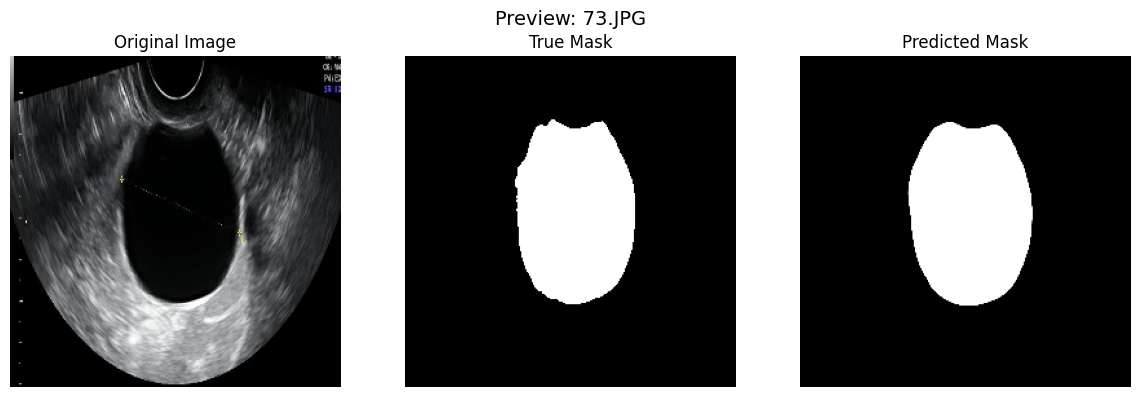

In [ ]:
preview_random_prediction(model, test_x, test_y)


In [ ]:
import numpy as np
import cv2
import os
from tqdm import tqdm

def predict_and_save(model, image_path, mask_path, output_dir):
    # Đọc ảnh
    img = read_image(image_path.encode('utf-8'))
    true_mask = read_mask(mask_path.encode('utf-8'))

    img_input = np.expand_dims(img, axis=0)
    pred_mask = model.predict(img_input)[0]


    name = os.path.basename(image_path).split('.')[0]
    out_path = os.path.join(output_dir, name)
    os.makedirs(out_path, exist_ok=True)

    # Lưu ảnh gốc
    img_save = (img * 255).astype(np.uint8)
    img_save = cv2.cvtColor(img_save, cv2.COLOR_RGB2BGR)
    cv2.imwrite(os.path.join(out_path, f"{name}_image.jpg"), img_save)

    # Lưu mask thật
    mask_save = (true_mask * 255).astype(np.uint8)
    cv2.imwrite(os.path.join(out_path, f"{name}_true_mask.png"), mask_save)

    # Lưu mask dự đoán
    pred_mask_save = (pred_mask * 255).astype(np.uint8)
    cv2.imwrite(os.path.join(out_path, f"{name}_pred_mask.png"), pred_mask_save)

def process_predictions(model, data, output_dir):
    x_data, y_data = data
    os.makedirs(output_dir, exist_ok=True)

    for x_path, y_path in tqdm(zip(x_data, y_data), total=len(x_data)):
        predict_and_save(model, x_path, y_path, output_dir)


In [ ]:
output_dir = "/content/drive/MyDrive/OTU-2D-Dataset-main/OTU-2D-Dataset-main/dataset_split_/prediction_with_and_without_haze"
process_predictions(model, (test_x, test_y), output_dir)


  0%|          | 0/146 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


  1%|          | 1/146 [00:01<04:18,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


  1%|▏         | 2/146 [00:02<02:55,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


  2%|▏         | 3/146 [00:03<02:35,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


  3%|▎         | 4/146 [00:11<08:59,  3.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


  3%|▎         | 5/146 [00:12<06:33,  2.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


  4%|▍         | 6/146 [00:13<05:07,  2.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


  5%|▍         | 7/146 [00:15<04:44,  2.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


  5%|▌         | 8/146 [00:16<04:06,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


  6%|▌         | 9/146 [00:17<03:27,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


  7%|▋         | 10/146 [00:18<03:08,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


  8%|▊         | 11/146 [00:19<02:57,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


  8%|▊         | 12/146 [00:20<02:50,  1.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


  9%|▉         | 13/146 [00:21<02:35,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 10%|▉         | 14/146 [00:22<02:20,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 10%|█         | 15/146 [00:23<02:10,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 11%|█         | 16/146 [00:24<02:00,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 12%|█▏        | 17/146 [00:25<02:00,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 12%|█▏        | 18/146 [00:26<01:57,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 13%|█▎        | 19/146 [00:26<01:54,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 14%|█▎        | 20/146 [00:27<01:51,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 14%|█▍        | 21/146 [00:28<01:49,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 15%|█▌        | 22/146 [00:29<01:45,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 16%|█▌        | 23/146 [00:30<01:46,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 16%|█▋        | 24/146 [00:31<01:41,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 17%|█▋        | 25/146 [00:31<01:38,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 18%|█▊        | 26/146 [00:32<01:38,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 18%|█▊        | 27/146 [00:33<01:40,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 19%|█▉        | 28/146 [00:34<01:43,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 20%|█▉        | 29/146 [00:35<01:52,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 21%|██        | 30/146 [00:36<01:47,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 21%|██        | 31/146 [00:37<01:44,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 22%|██▏       | 32/146 [00:38<01:40,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 23%|██▎       | 33/146 [00:39<01:38,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 23%|██▎       | 34/146 [00:39<01:35,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 24%|██▍       | 35/146 [00:40<01:31,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 25%|██▍       | 36/146 [00:41<01:31,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 25%|██▌       | 37/146 [00:42<01:29,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 26%|██▌       | 38/146 [00:43<01:27,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 27%|██▋       | 39/146 [00:43<01:27,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 27%|██▋       | 40/146 [00:44<01:24,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 28%|██▊       | 41/146 [00:45<01:23,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 29%|██▉       | 42/146 [00:46<01:26,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 29%|██▉       | 43/146 [00:47<01:25,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 30%|███       | 44/146 [00:48<01:28,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 31%|███       | 45/146 [00:48<01:26,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 32%|███▏      | 46/146 [00:49<01:23,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 32%|███▏      | 47/146 [00:50<01:21,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 33%|███▎      | 48/146 [00:51<01:19,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 34%|███▎      | 49/146 [00:52<01:19,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 34%|███▍      | 50/146 [00:52<01:16,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 35%|███▍      | 51/146 [00:53<01:19,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 36%|███▌      | 52/146 [00:54<01:16,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 36%|███▋      | 53/146 [00:55<01:16,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 37%|███▋      | 54/146 [00:56<01:14,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 38%|███▊      | 55/146 [00:56<01:12,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 38%|███▊      | 56/146 [00:57<01:12,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 39%|███▉      | 57/146 [00:58<01:16,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 40%|███▉      | 58/146 [00:59<01:20,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 40%|████      | 59/146 [01:00<01:18,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 41%|████      | 60/146 [01:01<01:17,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 42%|████▏     | 61/146 [01:02<01:16,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 42%|████▏     | 62/146 [01:03<01:14,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 43%|████▎     | 63/146 [01:04<01:11,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 44%|████▍     | 64/146 [01:04<01:09,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 45%|████▍     | 65/146 [01:05<01:07,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 45%|████▌     | 66/146 [01:06<01:05,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 46%|████▌     | 67/146 [01:07<01:03,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 47%|████▋     | 68/146 [01:10<01:55,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 47%|████▋     | 69/146 [01:11<01:39,  1.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 48%|████▊     | 70/146 [01:12<01:26,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 49%|████▊     | 71/146 [01:12<01:20,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 49%|████▉     | 72/146 [01:13<01:14,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 50%|█████     | 73/146 [01:14<01:08,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 51%|█████     | 74/146 [01:15<01:04,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 51%|█████▏    | 75/146 [01:16<01:01,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 52%|█████▏    | 76/146 [01:17<01:00,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 53%|█████▎    | 77/146 [01:17<00:58,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 53%|█████▎    | 78/146 [01:18<00:56,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 54%|█████▍    | 79/146 [01:19<00:59,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 55%|█████▍    | 80/146 [01:20<00:57,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 55%|█████▌    | 81/146 [01:21<00:54,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 56%|█████▌    | 82/146 [01:22<00:53,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 57%|█████▋    | 83/146 [01:23<00:56,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 58%|█████▊    | 84/146 [01:23<00:54,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 58%|█████▊    | 85/146 [01:24<00:55,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 59%|█████▉    | 86/146 [01:25<00:51,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 60%|█████▉    | 87/146 [01:26<00:57,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 60%|██████    | 88/146 [01:27<00:53,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 61%|██████    | 89/146 [01:28<00:50,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 62%|██████▏   | 90/146 [01:29<00:55,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 62%|██████▏   | 91/146 [01:30<00:50,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 63%|██████▎   | 92/146 [01:31<00:48,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 64%|██████▎   | 93/146 [01:32<00:46,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 64%|██████▍   | 94/146 [01:33<00:45,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 65%|██████▌   | 95/146 [01:33<00:42,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 66%|██████▌   | 96/146 [01:34<00:40,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 66%|██████▋   | 97/146 [01:35<00:41,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 67%|██████▋   | 98/146 [01:36<00:44,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 68%|██████▊   | 99/146 [01:37<00:42,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 68%|██████▊   | 100/146 [01:38<00:40,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 69%|██████▉   | 101/146 [01:39<00:38,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 70%|██████▉   | 102/146 [01:39<00:37,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 71%|███████   | 103/146 [01:40<00:35,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 71%|███████   | 104/146 [01:41<00:36,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 72%|███████▏  | 105/146 [01:42<00:35,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 73%|███████▎  | 106/146 [01:43<00:33,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 73%|███████▎  | 107/146 [01:44<00:32,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 74%|███████▍  | 108/146 [01:44<00:31,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 75%|███████▍  | 109/146 [01:45<00:29,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 75%|███████▌  | 110/146 [01:46<00:28,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 76%|███████▌  | 111/146 [01:47<00:29,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 77%|███████▋  | 112/146 [01:48<00:28,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 77%|███████▋  | 113/146 [01:49<00:28,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 78%|███████▊  | 114/146 [01:49<00:26,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 79%|███████▉  | 115/146 [01:50<00:26,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 79%|███████▉  | 116/146 [01:51<00:25,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 80%|████████  | 117/146 [01:52<00:23,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 81%|████████  | 118/146 [01:53<00:23,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 82%|████████▏ | 119/146 [01:54<00:22,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 82%|████████▏ | 120/146 [01:54<00:21,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 83%|████████▎ | 121/146 [01:55<00:20,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 84%|████████▎ | 122/146 [01:56<00:19,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 84%|████████▍ | 123/146 [01:57<00:18,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 85%|████████▍ | 124/146 [01:58<00:18,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 86%|████████▌ | 125/146 [01:59<00:17,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 86%|████████▋ | 126/146 [01:59<00:16,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 87%|████████▋ | 127/146 [02:01<00:19,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 88%|████████▊ | 128/146 [02:02<00:17,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 88%|████████▊ | 129/146 [02:03<00:16,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 89%|████████▉ | 130/146 [02:03<00:14,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 90%|████████▉ | 131/146 [02:04<00:13,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 90%|█████████ | 132/146 [02:05<00:12,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 91%|█████████ | 133/146 [02:06<00:10,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 92%|█████████▏| 134/146 [02:07<00:09,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 92%|█████████▏| 135/146 [02:07<00:09,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 93%|█████████▎| 136/146 [02:08<00:08,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 94%|█████████▍| 137/146 [02:09<00:07,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 95%|█████████▍| 138/146 [02:10<00:06,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 95%|█████████▌| 139/146 [02:11<00:06,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 96%|█████████▌| 140/146 [02:12<00:05,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 97%|█████████▋| 141/146 [02:13<00:04,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 97%|█████████▋| 142/146 [02:13<00:03,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 98%|█████████▊| 143/146 [02:14<00:02,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 99%|█████████▊| 144/146 [02:15<00:01,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 99%|█████████▉| 145/146 [02:16<00:00,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


100%|██████████| 146/146 [02:17<00:00,  1.06it/s]
